#Face Mask Detection Model

In [1]:
%pip install kagglehub

In [2]:
# นำเข้า modules ของ libraries
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.pyplot import figure
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from kagglehub import login, dataset_download
from pandas import DataFrame

In [3]:
# Login เข้า Kaggle (ต้องดาวโหลด์ใบ credentail จาก kaggle ก่อนแล้วเอา username กับ key มากรอก)
# หรือถ้าไม่มีให้ใช้ข้อมูลด้านล่างต่อไปนี้

# ให้นำค่า value ไปกรอกในฟอร์มของ kaggle
kaggle_api = {
    "username":"warinsaipanya",
    "key":"e9d6ec16f057b50fac90908de9990b27"
}

login()

In [4]:
# ดาวโหลด์ตัว datasets จาก kaggle เก็บไว้ใน path ที่ระบุ
path = dataset_download("andrewmvd/face-mask-detection")
print(f"path ของไฟล์ dataset อยู่ที่: {path}")

100%|██████████| 398M/398M [00:07<00:00, 57.9MB/s]

Extracting files...


path ของไฟล์ dataset อยู่ที่: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [5]:
# classes เป็น list ไว้เก็บคำตอบ
classes = ["with_mask", "without_mask"]

In [6]:
# ชื่อ models ทั้งหมด
model_names = ("Neural Network", "KNN", "Desicion Tree", "Random Forest")

# สร้างตัวแปรเก็บเป็น list ไว้เก็บค่าตัวเลขผลลัพธ์ของ model เพื่อนำไป plot graph และ ทำตาราง
accuracy_values = []
precision_values = []
recall_values = []

# function สำหรับเพิ่มค่า element ให้ตัวแปร list ด้านบน
def add_elements(accuracy, precision, recall):
  accuracy_values.append(accuracy)
  precision_values.append(precision)
  recall_values.append(recall)

In [7]:
# path ที่เก็บข้อมูลรูปภาพไว้ train
folder_path = f"{path}/images"
# path ที่เก็บข้อมูลไฟล์ xml
xml_folder = f"{path}/annotations"

In [8]:
# function สำหรับการอ่านข้อมูลในไฟล์ xml
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # เก็บข้อมูลใน tag ของ object
    objects = []

    # หา tag filename แล้วอ่านข้อมูลด้านใน content
    filename = root.find("filename").text
    # หา tag size
    size = root.find("size")
    # อ่านค่า width และ height ใน element size
    width = size.find("width").text
    height = size.find("height").text

    # วน loop หา element ที่มีชื่อว่า object และได้กลับคืนมาเป็น list แล้ววน loop
    for obj in root.findall("object"):
        # หา tag ที่ชื่อ name แล้วอ่าน content ด้านในเก็บ class คำตอบของรูป
        label = obj.find("name").text
        # หา tag bndbox
        bndbox = obj.find("bndbox")
        # อ่านข้อมูลด้านใน element bndbox แล้วแปลงค่าเป็น int
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        # เพื่อ dictionary เข้าไปใน list
        objects.append({"filename": filename, "size": { "width": width, "height": height }, "label": label, "bndbox": [xmin, ymin, xmax, ymax]})

    return objects

In [9]:
# ฟังก์ชัน extract_number จะพยายามค้นหาตัวเลขภายในชื่อไฟล์ หากพบตัวเลข จะส่งคืนตัวเลขนั้นเป็นจำนวนเต็ม หากไม่พบตัวเลขใดๆ จะส่งคืน -1
def extract_number(filename):
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else -1

In [10]:
# list เก็บชื่อไฟล์ xml แบบเรียงลำดับชื่อไฟล์เป็นไฟล์ข้อมูลสำหรับแต่หล่ะรูปภาพ
xml_files = sorted(os.listdir(xml_folder), key=extract_number)
# สร้าง object ของ label encoder ไว้ normalize ตัว label ของรูป
encoder = LabelEncoder()

# แสดงผล list ที่เก็บไฟล์ xml ไว้
print(xml_files)

['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss2.xml', 'maksssksksss3.xml', 'maksssksksss4.xml', 'maksssksksss5.xml', 'maksssksksss6.xml', 'maksssksksss7.xml', 'maksssksksss8.xml', 'maksssksksss9.xml', 'maksssksksss10.xml', 'maksssksksss11.xml', 'maksssksksss12.xml', 'maksssksksss13.xml', 'maksssksksss14.xml', 'maksssksksss15.xml', 'maksssksksss16.xml', 'maksssksksss17.xml', 'maksssksksss18.xml', 'maksssksksss19.xml', 'maksssksksss20.xml', 'maksssksksss21.xml', 'maksssksksss22.xml', 'maksssksksss23.xml', 'maksssksksss24.xml', 'maksssksksss25.xml', 'maksssksksss26.xml', 'maksssksksss27.xml', 'maksssksksss28.xml', 'maksssksksss29.xml', 'maksssksksss30.xml', 'maksssksksss31.xml', 'maksssksksss32.xml', 'maksssksksss33.xml', 'maksssksksss34.xml', 'maksssksksss35.xml', 'maksssksksss36.xml', 'maksssksksss37.xml', 'maksssksksss38.xml', 'maksssksksss39.xml', 'maksssksksss40.xml', 'maksssksksss41.xml', 'maksssksksss42.xml', 'maksssksksss43.xml', 'maksssksksss44.xml', 'maksssksksss45.xml

### ตาราง

In [11]:
# ตัวแปร list ไว้เก็บข้อมูลที่ได้จากการอ่านค่าข้อมูลจากไฟล์ .xml เพื่อนำข้อมูลไปทำเป็นตาราง dataframe
filenames = []
labels = []
widths = []
heights = []
xmins = []
ymins = []
xmaxes = []
ymaxes= []

# วน loop แต่ล่ะชื่อ xml file
for file in xml_files:

    # เอา path ของที่เก็บไฟล์ xml  มา join กับชื่อไฟล์ จะได้ตำแหน่ง path ที่แท้จริงของไฟล์ xml
    file_path = os.path.join(xml_folder, file)

    # เช็คตรวจสอบไฟล์ว่ามี path ไฟล์นั้นอยู่จริงไหม หรือไฟล์นั้นไม่ใช่ไฟล์ นามสกุล .xml ให้ข้าม loop นั้น
    if not os.path.isfile(file_path) or not file.lower().endswith('.xml'):
        continue

    # อ่านค่า dictionary อันแรกเพราะต้องการแค่คนเดียวใน 1 รูป
    objects = parse_xml(file_path)

    for object in objects:
      # เพิ่มค่า elements เข้าไปใน list
      filenames.append(object["filename"])
      labels.append(object["label"])
      widths.append(object["size"]["width"])
      heights.append(object["size"]["height"])
      xmins.append(object["bndbox"][0])
      ymins.append(object["bndbox"][1])
      xmaxes.append(object["bndbox"][2])
      ymaxes.append(object["bndbox"][3])

In [12]:
# เตรียมข้อมูลเป็น dictionary แล้วส่งค่าเข้าไปใน dataframe
data = {
    "filename": filenames,
    "label": labels,
    "width": widths,
    "height": heights,
    "xmin": xmins,
    "ymin": ymins,
    "xmax": xmaxes,
    "ymax": ymaxes
}

# สร้าง object ของ dataframe
df = DataFrame(data)

# แสดงข้อมูลและรายละเอียดตาราง
print(df.head())
print(df.info())
df.describe()

            filename         label width height  xmin  ymin  xmax  ymax
0  maksssksksss0.png  without_mask   512    366    79   105   109   142
1  maksssksksss0.png     with_mask   512    366   185   100   226   144
2  maksssksksss0.png  without_mask   512    366   325    90   360   141
3  maksssksksss1.png     with_mask   400    156   321    34   354    69
4  maksssksksss1.png     with_mask   400    156   224    38   261    73
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   width     4072 non-null   object
 3   height    4072 non-null   object
 4   xmin      4072 non-null   int64 
 5   ymin      4072 non-null   int64 
 6   xmax      4072 non-null   int64 
 7   ymax      4072 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 254.6+ KB
None


,xmin,ymin,xmax,ymax
count,4072.000000,4072.000000,4072.000000,4072.000000
mean,182.207024,85.780697,213.356090,120.785609
std,104.471254,52.571821,102.712267,70.355098
min,1.000000,1.000000,8.000000,6.000000
25%,96.000000,49.000000,134.000000,73.000000
50%,177.000000,75.000000,212.000000,103.000000
75%,266.000000,113.000000,292.000000,148.000000
max,569.000000,330.000000,592.000000,495.000000


In [13]:
# แสดงจำนวนคำตอบของ class ทั้งหมด
for label in classes:
  print(f'{label} = {len(df[df["label"] == label])}' )

with_mask = 3232
without_mask = 717


/usr/local/lib/python3.11/dist-packages/matplotlib/table.py:820: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


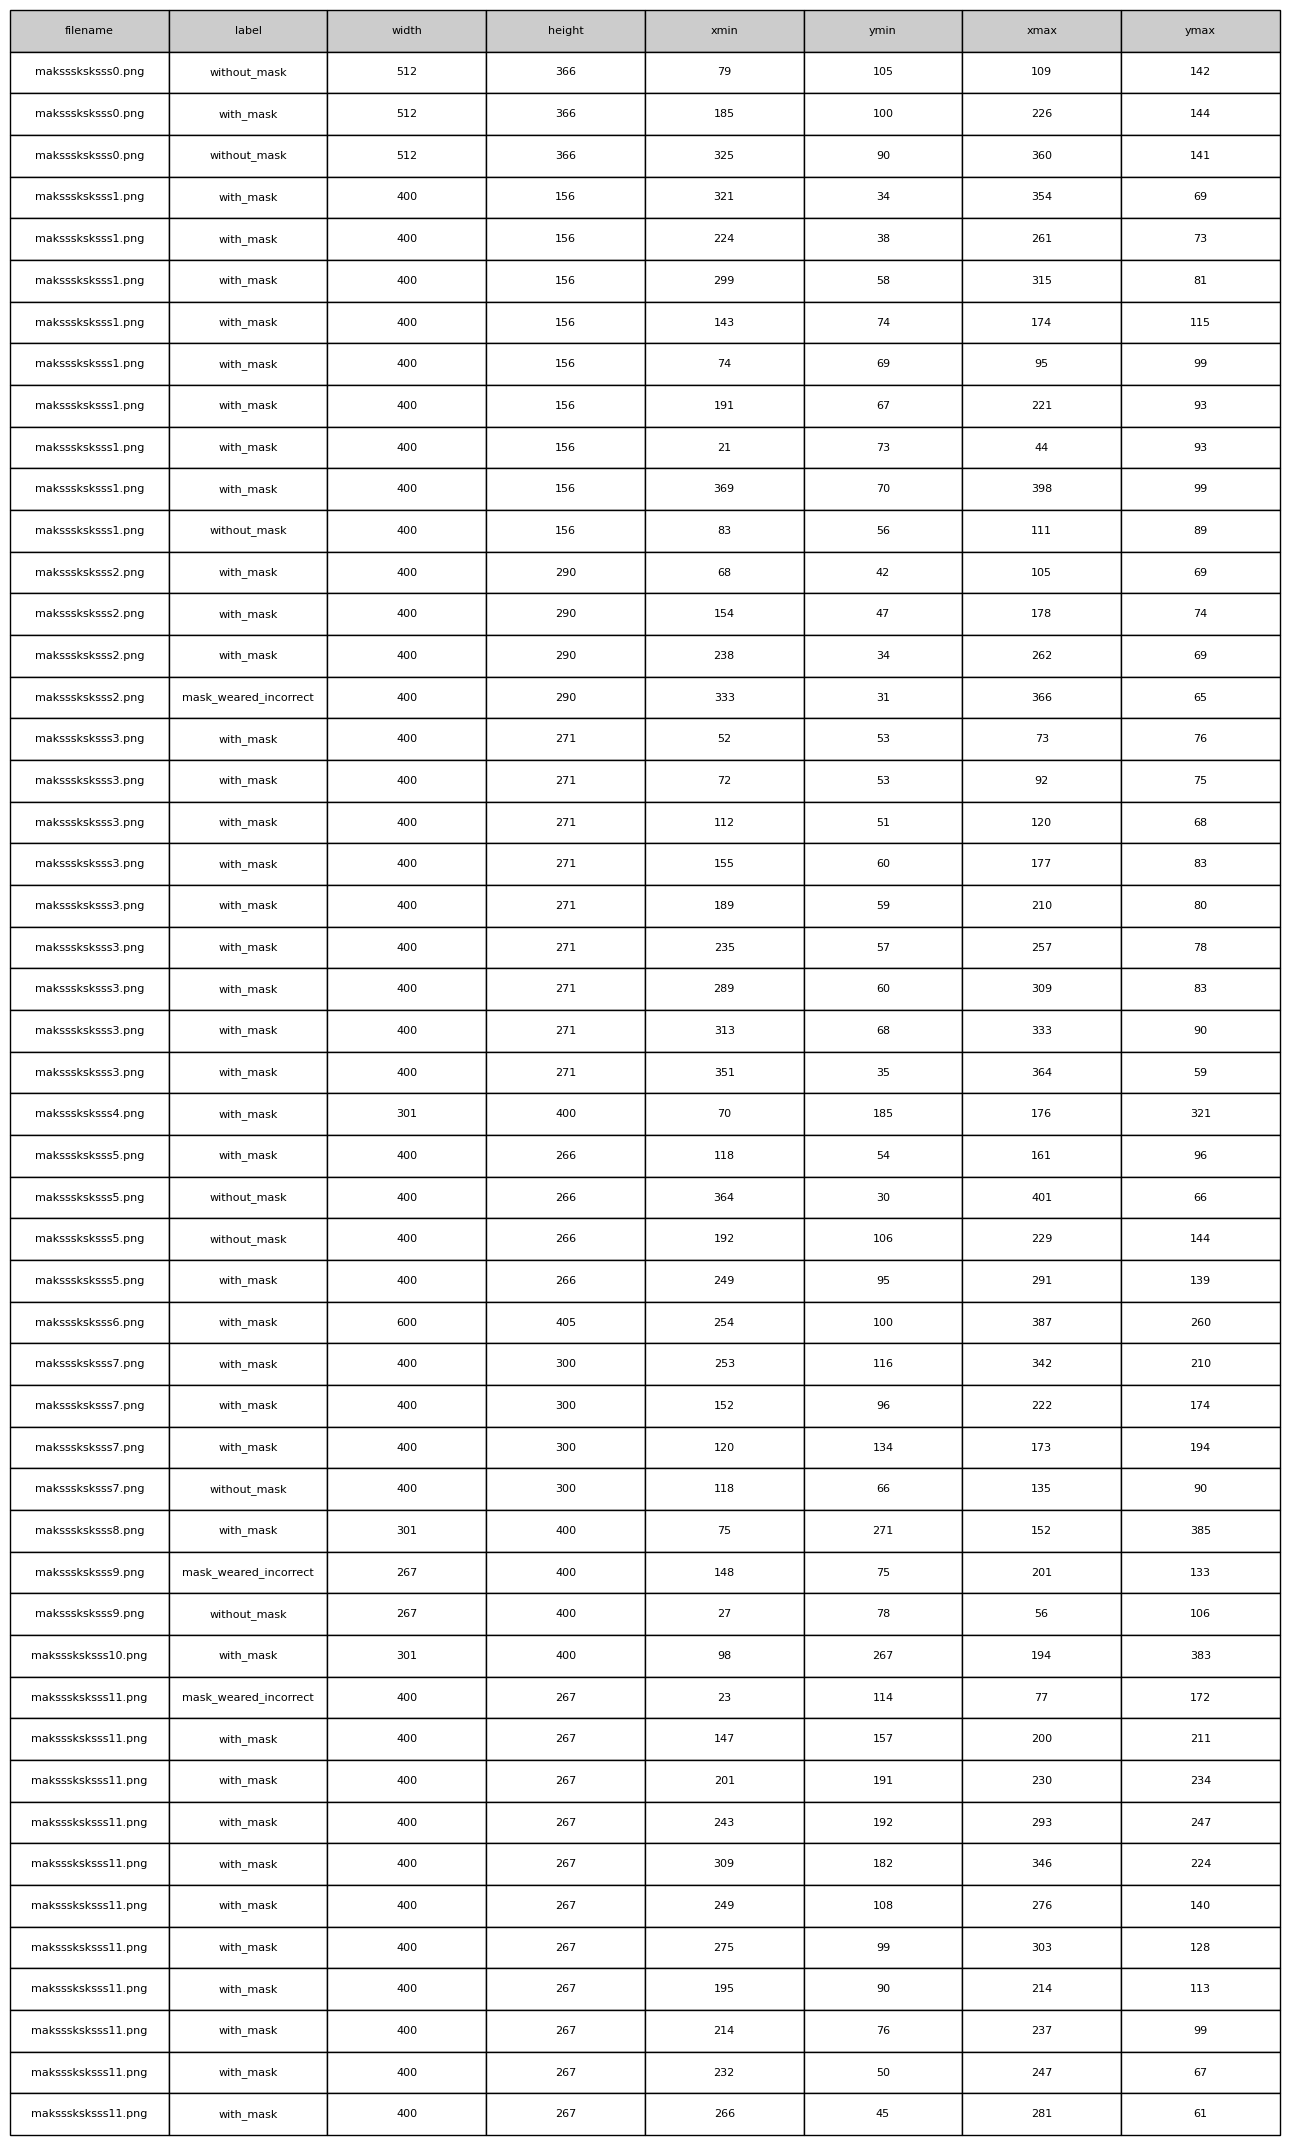

In [14]:
# กำหนดจำนวนแถวที่จะนำไปแสดงในตาราง
n = 50
# สร้าง list เพื่อเก็บ cells ในแต่ล่ะแถว
cell_texts = []

# วน loop ตามจำนวนรอบที่กำหนด
for i in range(n):
    # เพิ่มค่า cell ของแต่ล่ะแถว
    cell_texts.append(df.iloc[i])

# plot สร้าง table เป็นรูปภาพ
table = plt.table(cellText=cell_texts,
                  colLabels=df.columns,
                  colWidths=[0.4 for i in range(n)],
                  loc='center',
                  colColours=['0.8' for j in range(n)],
                  cellLoc='center'
              )
# ปรับขนาดของตารางในแนวแกน x และ y
table.scale(0.8, 2.5)

# ปิดใช้แกนของกราฟ
plt.axis('off')
# แสดงกราฟ
plt.show()

In [15]:
# list สำหรับเก็บ path ของไฟล์ xml และ รูปภาพ
image_paths = []
xml_paths = []

# วน loop รับ element แต่ล่ะไฟล์
for xml_file in xml_files:
  # แทนชื่อไฟล์นามสกุล .xml เป็น .png
  image_file = xml_file.replace(".xml", ".png")
  # เอา path folder ที่เก็บรูปภาพ มา join กับชื่อไฟล์รูปภาพ
  image_path = os.path.join(folder_path, image_file)
  # เพิ่ม element ของ path รูปภาพ
  image_paths.append(image_path)

  # path ไฟล์ xml มา join กับไฟล์ xml
  xml_path = os.path.join(xml_folder, xml_file)
  # เพิ่ม element ของ path xml
  xml_paths.append(xml_path)

# แสดงรายการใน list
print(image_paths)
print(xml_paths)

['/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss0.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss1.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss2.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss3.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss4.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss5.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss6.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss7.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss8.png', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksk

In [16]:
# กำหนดค่า max ของ
max_mask = 700

# สร้าง list เก็บ ข้อมูล และ คำตอบ
x_data = []
y_data = []

# เก็บเลขจำนวนคนที่ใส่ mask ทั้งหมด
total_with_mask = 0
# เก็บเลขจำนวนคนที่ไม่ได้ใส่ mask ทั้งหมด
total_without_mask = 0

# เก็บข้อมูลคนใส่ mask และ ไม่ใส่ mask แยกตาม list
with_mask_data = []
without_mask_data = []

In [17]:
# วน loop file xml แต่ล่ะไฟล์ (ชื่อไฟล์ xml)
for file in xml_files:
    # join path ของ folder รูปภาพ กับชื่อไฟล์ xml จะได้ path ที่แท้จริงของไฟล์ .xml
    file_path = os.path.join(xml_folder, file)

    # เช็คถ้า path ของไฟล์นั้นมีอยู่จริง และ เช็คว่าต้องไม่ใช่ไฟล์ .xml
    if not os.path.isfile(file_path) or not file.lower().endswith('.xml'):
        # ข้าม loop รอบนั้น
        continue

    # เขียน try catch ดักจับ exception ที่ออกมา
    try:
        # แปลงไฟล์ นามสกุล .xml เป็น .png
        image_name = file.replace(".xml", ".png")
        # อ่านค่า path ที่แท้จริงที่เก็บรูปภาพ png
        image_path = os.path.join(folder_path, image_name)

        # เช็คเงื่อนไขถ้า path ของรูปภาพไม่มีอยู่ ให้ข้าม loop นั้นไป
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # เปิดรูปภาพตามตำแหน่งของ path รูปภาพแล้วแปลงรูปภาพนั้นให้เป็น grayscale
        img = Image.open(image_path).convert('L')
        # ปรับขนาดของรูปภาพที่ size หลายขนาดให้เป็นขนาด 512 x 512 (height = width)
        img = img.resize((512, 512))
        # เพิ่ม element เข้าไปใน list โดยให้รูปภาพปรับขนาดรูปร่างความกว้างและความสูงเป็น 512 และ มีช่องสีแค่ 1
        img_array = np.array(img).reshape(512, 512, 1)

        # เรียกใช้ function ได้เป็น list ที่เก็บ dictionary ที่เป็นคุณสมบัติของรูปภาพ
        objects = parse_xml(file_path)

        # วน loop รับค่า element ของ object ทีล่ะอัน
        for obj in objects:
            # อ่านคำตอบของรูปภาพ
            label = obj["label"]

            # เช็คว่าใช้ class with_mask ไหม และ จำนวนทั้งหมดของรูปต้องยังไม่เกิน 700
            if label == "with_mask" and total_with_mask < 700:
                # เพิ่มจำนวนคนใส่ mask
                total_with_mask += 1
                # เพิ่ม element ตัว array
                with_mask_data.append(img_array)

            # เช็คว่าใช้ class without_mask ไหม และ จำนวนทั้งหมดของรูปต้องยังไม่เกิน 700
            elif label == "without_mask" and total_without_mask < 700:
                # เพิ่มจำนวนคนไม่ใส่ mask
                total_without_mask += 1
                # เพิ่ม element ตัว array
                without_mask_data.append(img_array)

    except Exception as e:
        print(f"Error processing {file}: {e}")


# กำหนดจำนวนข้อมูลรูปจของแต่ล่ะ class อยู่ที่ 700
target_count = 700

# ปรับสมดุลข้อมูล: ทำให้จำนวนรูปภาพคนใส่/ไม่ใส่หน้ากากเท่ากัน (700 รูป)
# ถ้ารูปภาพไม่พอ จะทำซ้ำข้อมูลที่มีอยู่
if len(with_mask_data) < target_count:
    with_mask_data = with_mask_data * (target_count // len(with_mask_data)) + with_mask_data[:target_count % len(with_mask_data)]
if len(without_mask_data) < target_count:
    without_mask_data = without_mask_data * (target_count // len(without_mask_data)) + without_mask_data[:target_count % len(without_mask_data)]

# ตัดแต่งข้อมูลให้มี 700 รูปพอดี
with_mask_data = with_mask_data[:target_count]
without_mask_data = without_mask_data[:target_count]

# รวมรูปภาพทั้งหมด (x_data) และสร้างป้ายกำกับ (y_data): 1 = ใส่หน้ากาก, 0 = ไม่ใส่
x_data = with_mask_data + without_mask_data
y_data = [1] * len(with_mask_data) + [0] * len(without_mask_data)

# จับคู่รูปภาพกับป้ายกำกับ แล้วสุ่มข้อมูล
combined_data = list(zip(x_data, y_data))
np.random.shuffle(combined_data)
x_data, y_data = zip(*combined_data)

# แสดงผลลัพธ์
print(f"\nจำนวนคนที่ใส่หน้ากากทั้งหมด: {total_with_mask}")
print(f"จำนวนคนที่ไม่ใส่หน้ากากทั้งหมด: {total_without_mask}")


จำนวนคนที่ใส่หน้ากากทั้งหมด: 700
จำนวนคนที่ไม่ใส่หน้ากากทั้งหมด: 700


In [18]:
# แปลงให้เป็น array
x_data = np.array(x_data)
y_data = np.array(y_data)

# แปลงข้อมูล array จากชนิด unsigned int -> float และหารด้วย 255 เพิ่อแปลงเป็น grayscale
x_data = x_data.astype('float32') / 255.0

# แบ่งข้อมูล train และ test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [19]:
# แสดงผลขนาดรูปร่างของข้อมูล train และ test
# จำนวนข้อมูลรูปภาพมีทั้งหมด 1400 รูป แบ่งเป็น train 1120 รูป และ test 280 รูป
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1120, 512, 512, 1)
(280, 512, 512, 1)
(1120,)
(280,)


### Neural Netwoerk Model

In [20]:
# สร้าง object และ เพิ่ม layers ให้ model
model = Sequential([
    Flatten(input_shape=(512, 512, 1)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# train model 14 รอบ
model.fit(x_train, y_train, epochs=14)

Epoch 1/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.4955 - loss: 109.4609
Epoch 2/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6058 - loss: 11.6892
Epoch 3/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.6302 - loss: 3.1274
Epoch 4/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.6423 - loss: 1.4373
Epoch 5/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7767 - loss: 0.4683
Epoch 6/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7791 - loss: 0.4686
Epoch 7/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7697 - loss: 0.4827
Epoch 8/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.7778 - loss: 0.4736
Epoch 9/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7804 - loss: 0.4650
Epoch 10/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.8133 - loss: 0.4265
Epoch 11/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7915 - loss: 0.4414
Epoch 12/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accura

In [23]:
# คำนวณค่า accuracy และ ค่า loss ของ model
loss, accuracy = model.evaluate(x_test, y_test)

# แสดงค่า accuracy กับ loss ออกมา
print(f"Accuracy: {accuracy:.5f}")
print(f"Loss: {loss:.5f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.8395 - loss: 0.3976
Accuracy: 0.84286
Loss: 0.36563


In [24]:
# ทำนายค่าผลลัพธ์
y_pred = np.argmax(model.predict(x_test), axis=-1)

# คำนวณค่า precision และ recall
# Add average='weighted' for multiclass classification
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# แสดงผลลัพธ์
print(f"Precision: {precision}")
print(f"Recall: {recall}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step
Precision: 0.8428806390977444
Recall: 0.8428571428571429


In [25]:
# เรียกใช้ function เพิ่มค่าที่สำคัญเข้าไปใน list
add_elements(accuracy, precision, recall)

In [26]:
# แปลงจาก array 4 มิติให้เป็น array 2 มิติ
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)
# แปลงเป็๋น array 1 มิติ
y_train2 = y_train.ravel()
y_test2 = y_test.ravel()

In [27]:
# แสดงรูปร้่างของข้อมูล train และ test
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(1120, 262144)
(280, 262144)
(1120,)
(280,)


### KNN Model

In [28]:
# กำหนดโมเดล KNN
knn = KNeighborsClassifier(n_neighbors=15)

# ฝึกโมเดล KNN
knn.fit(x_train2, y_train2)

# ทำนายผลลัพธ์ในชุดทดสอบ
y_pred_knn = knn.predict(x_test2)

# คำนวณความแม่นยำของโมเดล KNN
accuracy_knn = accuracy_score(y_test2, y_pred_knn)

# คำนวณ  loss สำหรับ KNN โดยใช้ค่าความน่าจะเป็นจากการทำนาย
y_pred_prob = knn.predict_proba(x_test2)

# กำหนดคลาสที่ต้องการใช้ในการคำนวณ  loss
KNN_loss = log_loss(y_test2, y_pred_prob, labels=[0, 1])

# คำนวณ precision และ recall ของ KNN
precision_knn = precision_score(y_test2, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test2, y_pred_knn, average='weighted')

# เพิ่มค่าผลลัพธ์ของ KNN เข้าไปใน list สำหรับเปรียบเทียบ
add_elements(accuracy_knn, precision_knn, recall_knn)

# แสดงผลความแม่นยำของ KNN ,  precision , recall และ loss
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN Recall: {recall_knn:.4f}")
print(f"KNN Loss: {KNN_loss:.4f}")

KNN Accuracy: 0.7214
KNN Precision: 0.7453
KNN Recall: 0.7214
KNN Loss: 0.5151


### Desicion Tree Model

In [30]:
# สร้าง Decision Tree Model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# ฝึก Decision Tree Model
decision_tree_model.fit(x_train2, y_train2)

# ทำนายค่าผลลัพธ์จากข้อมูลทดสอบ
dt_y_pred = decision_tree_model.predict(x_test2)

# ทำนายค่าความน่าจะเป็นจาก Decision Tree Model
dt_y_prob = decision_tree_model.predict_proba(x_test2)

# คำนวณ Log Loss
dt_loss = log_loss(y_test2, dt_y_prob, labels=[0, 1])

# คำนวณ Precision, Recall สำหรับ Decision Tree
dt_precision = precision_score(y_test2, dt_y_pred, average='weighted')
dt_recall = recall_score(y_test2, dt_y_pred, average='weighted')

# คำนวณ Accuracy
dt_accuracy = decision_tree_model.score(x_test2, y_test2)

# แสดงผลลัพธ์ของ Decision Tree Model
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Decision Tree Precision: {dt_precision}")
print(f"Decision Tree Recall: {dt_recall}")
print(f"Decision Tree Loss: {dt_loss}")

# เพิ่มผลลัพธ์ของ Decision Tree ลงใน list
add_elements(dt_accuracy, dt_precision, dt_recall)

Decision Tree Accuracy: 0.8428571428571429
Decision Tree Precision: 0.8428806390977444
Decision Tree Recall: 0.8428571428571429
Decision Tree Loss: 3.2245308934248533


### Random Forest Model

In [31]:
# สร้าง model random forest
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
# train model
rfc_model.fit(x_train2, y_train2)

# คำนวณค่า precision และ ค่า recall
rfc_precision_score = precision_score(y_test2, rfc_model.predict(x_test2))
rfc_recall_score = recall_score(y_test2, rfc_model.predict(x_test2))

# คำนวณค่า accuracy
rfc_test_acc = accuracy_score(y_test2, rfc_model.predict(x_test2))

# loss
rfc_loss = log_loss(y_train2,rfc_model.predict_proba(x_train2))

# แสดงผลลัพธ์
print("RFC Test Accuracy:", rfc_test_acc)
print("RFC Loss:", rfc_loss)
print("RFC Precision Score:", rfc_precision_score)
print("RFC Recall Score:", rfc_recall_score)

# เพิ่มค่าผลลัพธ์เข้าไปใน list
add_elements(rfc_test_acc, rfc_precision_score, rfc_recall_score)

RFC Test Accuracy: 0.8642857142857143
RFC Loss: 0.1966775814361171
RFC Precision Score: 0.8716216216216216
RFC Recall Score: 0.8716216216216216


In [32]:
# ปริ้นค่าผลลัพธ์ที่เก็บมา
print(accuracy_values)
print(precision_values)
print(recall_values)

[0.8428571224212646, 0.7214285714285714, 0.8428571428571429, 0.8642857142857143]
[0.8428806390977444, 0.7452996185554325, 0.8428806390977444, 0.8716216216216216]
[0.8428571428571429, 0.7214285714285714, 0.8428571428571429, 0.8716216216216216]


### Plot graphs

In [33]:
# กำหนดค่าสีแต่ละ model ในกราฟแท่ง
bar_colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
# สร้าง list ไว้กำหนดป้ายแต่ล่ะป้ายที่จะแสดงในแกน y
acc_labels = []
pre_labels = []
rec_labels = []

In [34]:
# สร้าาง function สำหรับ plot graph
def plot_graph(title, y_label, y_labels, x_label = 'Models'):

  # ปรับขนาดของกราฟ
  figure(figsize=(10, 5.5))

  # แสดงกราฟค่า accuracy
  plt.bar(y_labels, accuracy_values, width=.5, label=model_names, color=bar_colors, edgecolor='0')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(title='Model Name', loc='lower right')
  plt.show()

In [35]:
# วน loop เพิ่มค่า y labels
for i, name in enumerate(model_names):
  acc_labels.append(f'{name} \n ACC = {round(accuracy_values[i], 4)}')
  pre_labels.append(f'{name} \n P = {round(precision_values[i], 4)}')
  rec_labels.append(f'{name} \n R = {round(recall_values[i], 4)}')

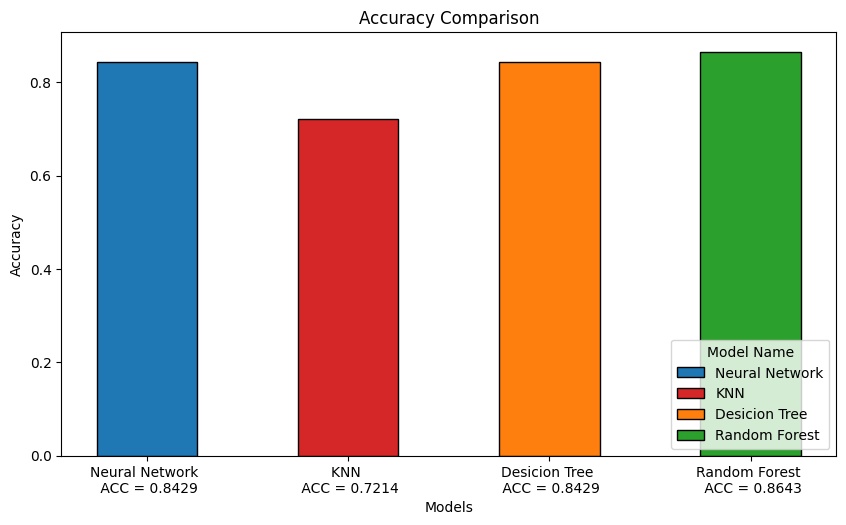

In [36]:
# เรียกใช้ function plot graph
# สร้างกราฟเปรียบเทียบค่า accuracy
plot_graph('Accuracy Comparison', 'Accuracy', acc_labels)

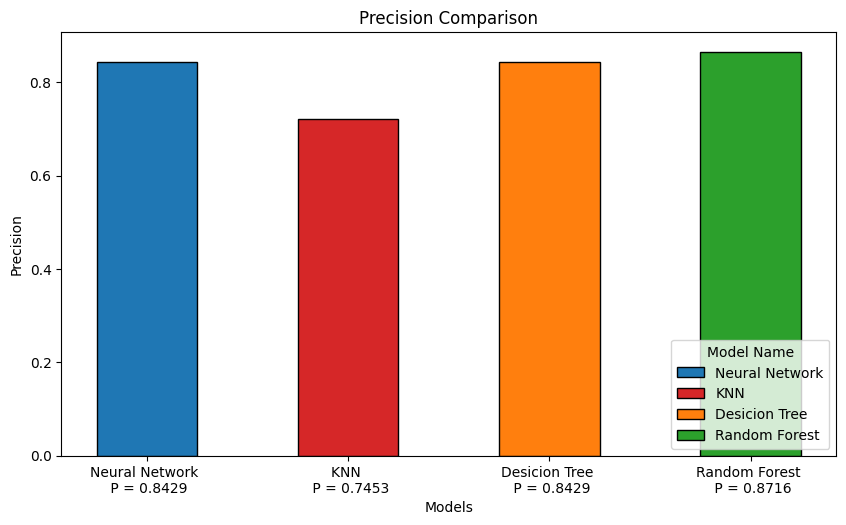

In [37]:
# สร้างกราฟเปรียบเทียบค่า precision
plot_graph('Precision Comparison', 'Precision', pre_labels)

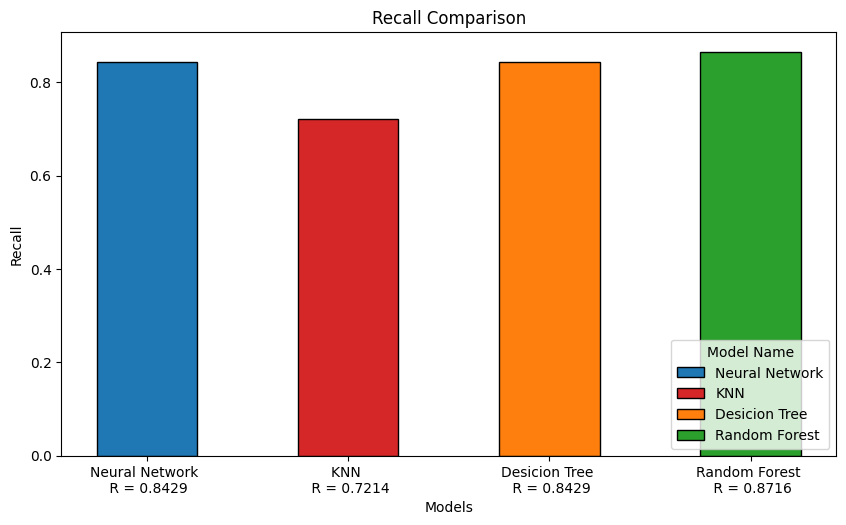

In [38]:
# สร้างกราฟเปรียบเทียบค่า recall
plot_graph('Recall Comparison', 'Recall', rec_labels)

### ทำนายค่า neural network model

รูปภาพที่ 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predict: with_mask
True: with_mask


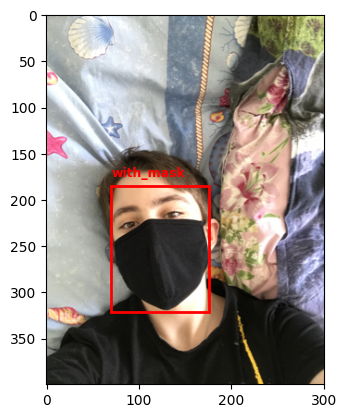



รูปภาพที่ 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Predict: without_mask
True: with_mask


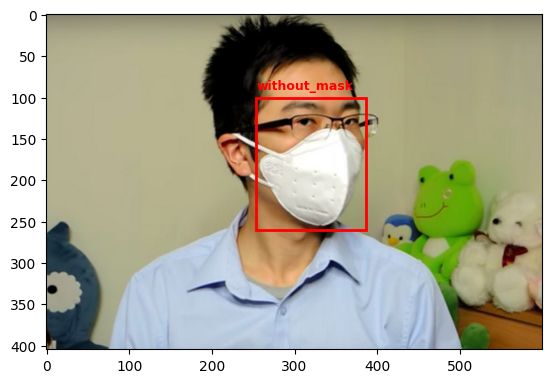



รูปภาพที่ 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Predict: without_mask
True: with_mask


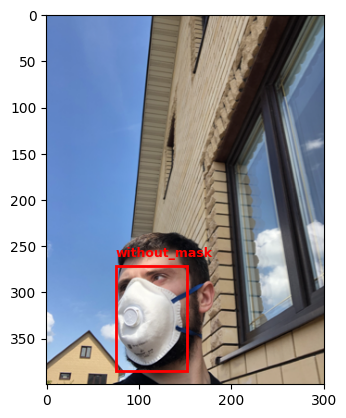



รูปภาพที่ 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predict: with_mask
True: with_mask


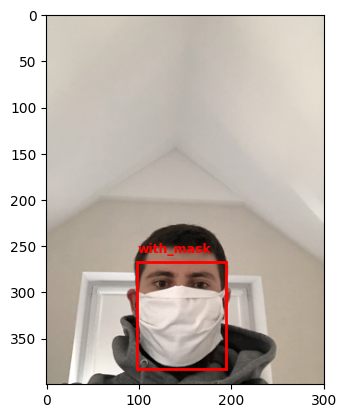



รูปภาพที่ 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predict: with_mask
True: without_mask


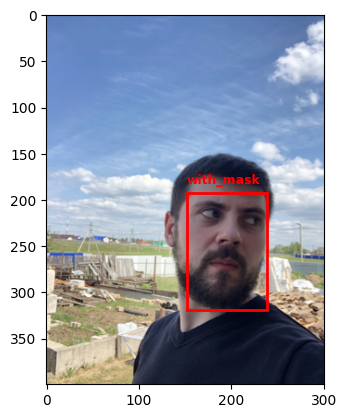



รูปภาพที่ 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predict: without_mask
True: with_mask


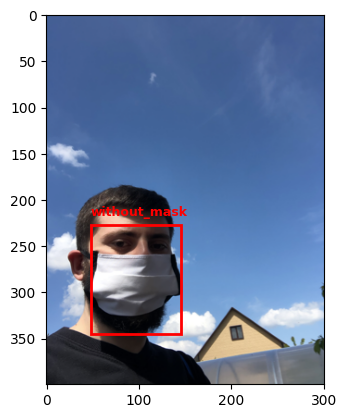

In [53]:
counter = 0
i = 0
indexes = []

while counter <= 5:
    # เก็บค่า path ไฟล์ .xml
    xml_path = xml_paths[i]
    # เก็บค่า path ไฟล์รูปภาพ .png
    image_path = image_paths[i]

    # อ่านค่า objects ใน xml
    objects = parse_xml(xml_path)

    if len(objects) == 1:
        counter += 1
        indexes.append(i)

    # เพิ่มค่าทีล่ะ 1
    i += 1

# Fit the encoder with the classes before using it
encoder.fit(classes)

# วน loop ตัวอย่างรูปมา 10 รอบ
for j in indexes:
    # เก็บค่า path ไฟล์ .xml
    xml_path = xml_paths[j]
    # เก็บค่า path ไฟล์รูปภาพ .png
    image_path = image_paths[j]
    # อ่านรูปภาพ
    image = cv2.imread(image_path)

    # ตรวจสอบรูปภาพอ่านค่าเป็นค่าว่างไหม
    if image is None:
        print(f"Error loading image: {image_path}")
        # โดดออกจาก loop รอบนั้น
        continue

    print(f'รูปภาพที่ {j + 1}')

    # สร้างรูปร่างและแกน
    fig, ax = plt.subplots(1)
    # แปลงรูปภาพแบบ BGR เป็นภาพ RGB แล้วแสดงขึ้นมาใน กราฟ
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # อ่านค่า objects ใน xml
    objects = parse_xml(xml_path)

    # วน loop อ่านค่า object ใน 1รูปภาพ
    for obj in objects:
        # เข้าถึง label คำตอบที่แท้จริง
        true_label = obj["label"]
        # เข้าถึงตัวเลขต่างๆใน bndbox
        bndbox = obj["bndbox"]

        # เก็บค่า element ของ bndbox เพื่อทำรูปสีเหลี่ยมผืนผ้า mark บนใบหน้า
        xmin = bndbox[0]
        ymin = bndbox[1]
        xmax = bndbox[2]
        ymax = bndbox[3]

        # เปิดรูปภาพตามตำแหน่งของ path รูปภาพแล้วแปลงรูปภาพนั้นให้เป็น grayscale
        input_img = Image.open(image_path).convert('L')
        # ปรับขนาดของรูปภาพที่ size หลายขนาดให้เป็นขนาด 512 x 512 (height = width)
        input_img = input_img.resize((512, 512))

        # ปรับเปลี่ยนขนาดรูปร่างของรูปภาพ
        input_image = np.array(input_img).reshape(1, 512, 512, 1)

        # แปลงค่าชนิด array เป็นชนิด ทศนิยม แล้วหารด้วย 255 เพื่อทำเป็น grayscale
        input_image = input_image.astype('float32') / 255.0

        # ทำนายโดยใช้ Neural Network model (model)
        predictions_nn = model.predict(input_image)
        predicted_class_index_nn = np.argmax(predictions_nn[0])
        predicted_class_label_nn = encoder.inverse_transform([predicted_class_index_nn])[0]  # Use encoder here

        # วาดรูปสี่เหลียมพืนผ้ารอบๆใบหน้าเพื่อทำการ mark
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        # เพิ่มรูปสี่เหลียมในกราฟ
        ax.add_patch(rect)

        # คำตอบของการทำนายของ model nueral network
        label = predicted_class_label_nn  # Use predicted_class_label_nn here
        # แสดง label คำตอบตรงที่ mark
        ax.text(xmin, ymin - 10, label, color='r', fontsize=9, weight='bold')

        # ปริ้นค่าผลลัพธ์การทำนาย และ ค่าคำตอบจริง
        print(f"Predict: {predicted_class_label_nn}")  # Use predicted_class_label_nn here
        print(f"True: {true_label}")

        # แสดงรูปภาพ
        plt.show()

        print("\n")

รูปภาพที่ 5
Predict: with_mask
True: with_mask


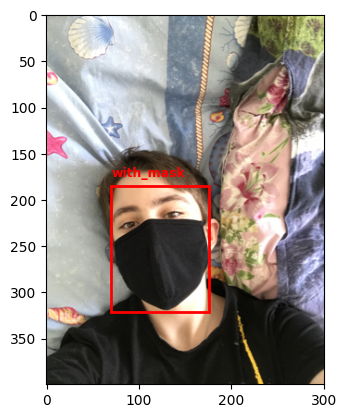



รูปภาพที่ 7
Predict: with_mask
True: with_mask


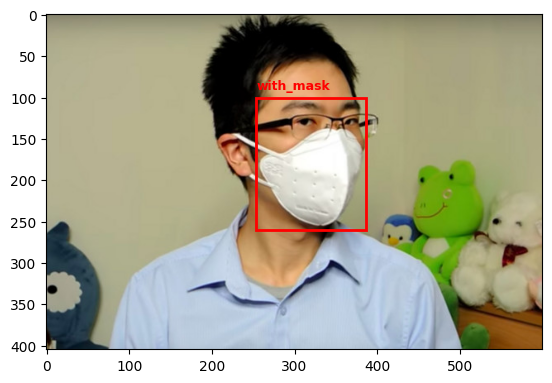



รูปภาพที่ 9
Predict: with_mask
True: with_mask


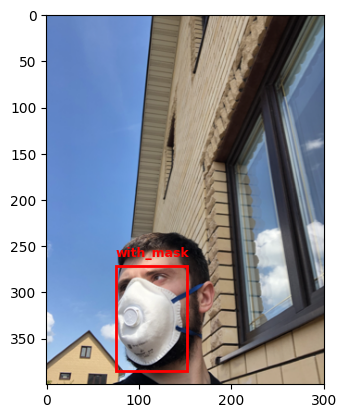



รูปภาพที่ 11
Predict: with_mask
True: with_mask


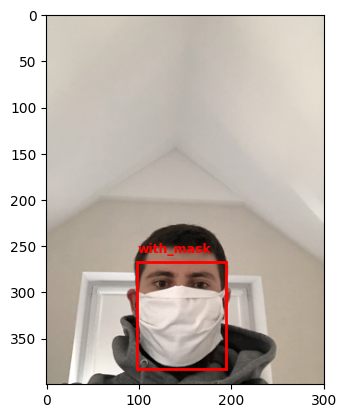



รูปภาพที่ 15
Predict: with_mask
True: without_mask


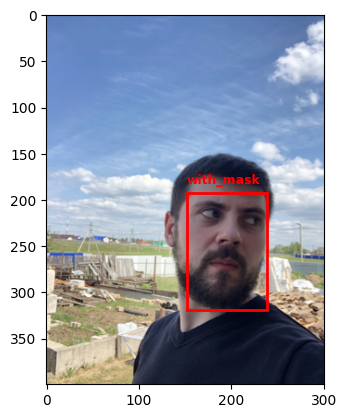



รูปภาพที่ 17
Predict: with_mask
True: with_mask


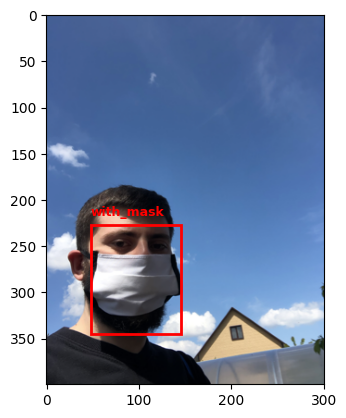

In [56]:
counter = 0
i = 0
indexes = []

while counter <= 5:
    # เก็บค่า path ไฟล์ .xml
    xml_path = xml_paths[i]
    # เก็บค่า path ไฟล์รูปภาพ .png
    image_path = image_paths[i]

    # อ่านค่า objects ใน xml
    objects = parse_xml(xml_path)

    if len(objects) == 1:
        counter += 1
        indexes.append(i)

    # เพิ่มค่าทีล่ะ 1
    i += 1

# Fit the encoder with the classes before using it
encoder.fit(classes)

# วน loop ตัวอย่างรูปมา 10 รอบ
for j in indexes:
    # เก็บค่า path ไฟล์ .xml
    xml_path = xml_paths[j]
    # เก็บค่า path ไฟล์รูปภาพ .png
    image_path = image_paths[j]
    # อ่านรูปภาพ
    image = cv2.imread(image_path)

    # ตรวจสอบรูปภาพอ่านค่าเป็นค่าว่างไหม
    if image is None:
        print(f"Error loading image: {image_path}")
        # โดดออกจาก loop รอบนั้น
        continue

    print(f'รูปภาพที่ {j + 1}')

    # สร้างรูปร่างและแกน
    fig, ax = plt.subplots(1)
    # แปลงรูปภาพแบบ BGR เป็นภาพ RGB แล้วแสดงขึ้นมาใน กราฟ
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # อ่านค่า objects ใน xml
    objects = parse_xml(xml_path)

    # วน loop อ่านค่า object ใน 1รูปภาพ
    for obj in objects:
        # เข้าถึง label คำตอบที่แท้จริง
        true_label = obj["label"]
        # เข้าถึงตัวเลขต่างๆใน bndbox
        bndbox = obj["bndbox"]

        # เก็บค่า element ของ bndbox เพื่อทำรูปสีเหลี่ยมผืนผ้า mark บนใบหน้า
        xmin = bndbox[0]
        ymin = bndbox[1]
        xmax = bndbox[2]
        ymax = bndbox[3]

        # เปิดรูปภาพตามตำแหน่งของ path รูปภาพแล้วแปลงรูปภาพนั้นให้เป็น grayscale
        input_img = Image.open(image_path).convert('L')
        # ปรับขนาดของรูปภาพที่ size หลายขนาดให้เป็นขนาด 512 x 512 (height = width)
        input_img = input_img.resize((512, 512))
        # ปรับเปลี่ยนขนาดรูปร่างของรูปภาพ
        input_image = np.array(input_img).reshape(1, 512, 512, 1)
        # แปลงค่าชนิด array เป็นชนิด ทศนิยม แล้วหารด้วย 255 เพื่อทำเป็น grayscale
        input_image = input_image.astype('float32') / 255.0

        # Reshape the input image for KNN
        input_image_knn = input_image.reshape(1, -1)


        # ทำนายโดยใช้ KNN model (knn)
        predicted_class_index_knn = knn.predict(input_image_knn)[0]
        predicted_class_label_knn = encoder.inverse_transform([predicted_class_index_knn])[0]

        # วาดรูปสี่เหลียมพืนผ้ารอบๆใบหน้าเพื่อทำการ mark
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        # เพิ่มรูปสี่เหลียมในกราฟ
        ax.add_patch(rect)

        # คำตอบของการทำนายของ model nueral network
        label = predicted_class_label_knn  # Use predicted_class_label_knn here
        # แสดง label คำตอบตรงที่ mark
        ax.text(xmin, ymin - 10, label, color='r', fontsize=9, weight='bold')

        # ปริ้นค่าผลลัพธ์การทำนาย และ ค่าคำตอบจริง
        print(f"Predict: {predicted_class_label_knn}")  # Use predicted_class_label_knn here
        print(f"True: {true_label}")

        # แสดงรูปภาพ
        plt.show()

        print("\n")